In [3]:
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
model = Model(name="psh")

In [32]:
# Indices
cascaded_reservoirs = np.arange(2)
upstream_reservoirs = {
    0: [],
    1: [0]
}
pumped_storage_reservoirs = np.arange(1)
hydro_units = {
    0: np.arange(2),
    1: np.arange(2)
}
pumped_storage_units = {
    0: np.arange(2)
}
periods = np.arange(10)
vertices = np.arange(3)

# Parameters
projected_prices = [10, 20, 15, 15, 15, 10, 10, 10, 5, 25]
period_length = 2
natural_inflow = np.ones(shape=(1,10)) * 2
travel_times = pd.DataFrame(data=[[0,1],[1,0]], index=cascaded_reservoirs, columns=cascaded_reservoirs)
spillage = pd.DataFrame(data=np.ones(shape=(2,10)), index=cascaded_reservoirs, columns=periods)

# Limits
v_min = 10
v_max = 20
v_min_p = 5
v_max_p = 10

p_min_g = 2
p_max_g = 8
p_min_p = 1
p_max_p = 4

q_min_g = 2
q_max_g = 6
q_min_p = 1
q_max_p = 4

In [24]:
def production_function(effi, water_head, water_discharge):
    result = 981 * 0.001 * effi * water_head * water_discharge
    return result

96.13799999999999

In [87]:
subregions = np.arange(10)
max_head = 10
min_head = 4
max_discharge = 30
min_discharge = 15
efficieny = 0.98

head_interval = (max_head - min_head) / (len(subregions) / 2)
discharge_interval = (max_discharge - min_discharge) / len(subregions)

h_vertices = np.zeros((2,2,10,3))
q_vertices = np.zeros((2,2,10,3))

# head vertices
for i in cascaded_reservoirs:
    for j in hydro_units[i]:
        for l in subregions:
            if l % 2 == 0:
                h_vertices[i,j,l,0] = min_head + l / 2 * head_interval # bottom left
                h_vertices[i,j,l,1] = min_head + l / 2 * head_interval + head_interval # bottom right
                h_vertices[i,j,l,2] = h_vertices[i,j,l,0] # top left

                h_vertices[i,j,l+1,0] = h_vertices[i,j,l,0] # top left
                h_vertices[i,j,l+1,1] = h_vertices[i,j,l,1]# top right
                h_vertices[i,j,l+1,2] = h_vertices[i,j,l,1] # bottom right

# discharge vertices
for i in cascaded_reservoirs:
    for j in hydro_units[i]:
        for l in subregions:
            if l % 2 == 0:
                q_vertices[i,j,l,0] = min_discharge # bottom left
                q_vertices[i,j,l,1] = min_discharge # bottom right
                q_vertices[i,j,l,2] = max_discharge # top left

                q_vertices[i,j,l+1,0] = max_discharge # top left
                q_vertices[i,j,l+1,1] = max_discharge # top right
                q_vertices[i,j,l+1,2] = min_discharge # bottom right

In [92]:
power_vertices = np.zeros((2,2,10,3))

for i in cascaded_reservoirs:
    for j in hydro_units[i]:
        for l in subregions:
            for r in vertices:
                power_vertices[i,j,l,r] = production_function(efficieny, h_vertices[i,j,l,r], q_vertices[i,j,l,r])


array([[[[ 57.6828 ,  74.98764, 115.3656 ],
         [115.3656 , 149.97528,  74.98764],
         [ 74.98764,  92.29248, 149.97528],
         [149.97528, 184.58496,  92.29248],
         [ 92.29248, 109.59732, 184.58496],
         [184.58496, 219.19464, 109.59732],
         [109.59732, 126.90216, 219.19464],
         [219.19464, 253.80432, 126.90216],
         [126.90216, 144.207  , 253.80432],
         [253.80432, 288.414  , 144.207  ]],

        [[ 57.6828 ,  74.98764, 115.3656 ],
         [115.3656 , 149.97528,  74.98764],
         [ 74.98764,  92.29248, 149.97528],
         [149.97528, 184.58496,  92.29248],
         [ 92.29248, 109.59732, 184.58496],
         [184.58496, 219.19464, 109.59732],
         [109.59732, 126.90216, 219.19464],
         [219.19464, 253.80432, 126.90216],
         [126.90216, 144.207  , 253.80432],
         [253.80432, 288.414  , 144.207  ]]],


       [[[ 57.6828 ,  74.98764, 115.3656 ],
         [115.3656 , 149.97528,  74.98764],
         [ 74.98764,  92.2

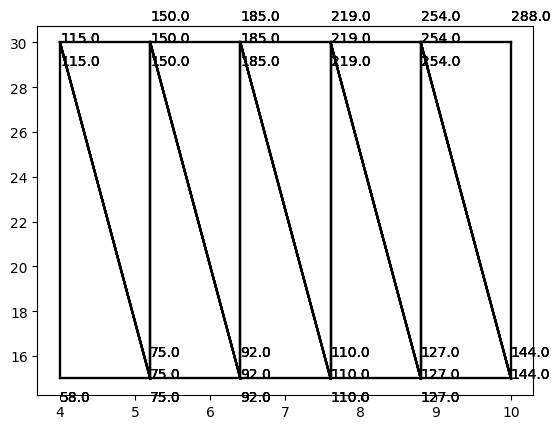

In [99]:
fig, ax = plt.subplots()
for i in cascaded_reservoirs:
    for j in hydro_units[i]:
        for l in subregions:
            ax.plot([h_vertices[i,j,l,0], h_vertices[i,j,l,1]], [q_vertices[i,j,l,0], q_vertices[i,j,l,1]], color='black')
            ax.plot([h_vertices[i,j,l,1], h_vertices[i,j,l,2]], [q_vertices[i,j,l,1], q_vertices[i,j,l,2]], color='black')
            ax.plot([h_vertices[i,j,l,2], h_vertices[i,j,l,0]], [q_vertices[i,j,l,2], q_vertices[i,j,l,0]], color='black')

            plt.annotate(round(power_vertices[i,j,l,0],0), xy=(h_vertices[i,j,l,0], q_vertices[i,j,l,0]), xytext=(h_vertices[i,j,l,0], q_vertices[i,j,l,0]-1))
            plt.annotate(round(power_vertices[i,j,l,1],0), xy=(h_vertices[i,j,l,1], q_vertices[i,j,l,1]), xytext=(h_vertices[i,j,l,1], q_vertices[i,j,l,1]+1))
            plt.annotate(round(power_vertices[i,j,l,2],0), xy=(h_vertices[i,j,l,2], q_vertices[i,j,l,2]), xytext=(h_vertices[i,j,l,2], q_vertices[i,j,l,2]))